In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys

if "../../" not in sys.path:
    sys.path.append("../../")
    print("[sys.path]:", sys.path)

[sys.path]: ['/usr/lib/python310.zip', '/usr/lib/python3.10', '/usr/lib/python3.10/lib-dynload', '', '/home/nadir/MoLiNER/.venv/lib/python3.10/site-packages', '../../']


In [3]:
from src.data.babel import BabelDataset
from src.data.hml3d import HML3DDataset

/home/nadir/MoLiNER/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
DECILES = [1, 2, 2.5, 3, 4, 5, 6, 7, 7.5, 8, 9, 9.5, 9.75, 9.99]

In [5]:
# Parameters
dataset_name = "hml3d"
pipeline_name = "hml3d"
split_names = ["train", "validation", "test"]

In [6]:
# Parameters
dataset_name = "babel"
pipeline_name = "babel-act-cat"
split_names = ["train", "validation"]


In [7]:
dataset_classes = {
    "babel": BabelDataset,
    "hml3d": HML3DDataset
}

In [8]:
if dataset_name not in dataset_classes.keys():
    raise ValueError(f"Dataset name must be one of {dataset_names}")
else:
    print(f"[parameters]: dataset_name = {dataset_name}")

[parameters]: dataset_name = babel


In [9]:
from src.data.pipelines._registery import PIPELINE_REGISTRY

pipeline_names = [name for names in PIPELINE_REGISTRY.values() for name in names]

if pipeline_name not in pipeline_names:
    raise ValueError(f"Pipeline '{pipeline_name}' is not registered. Available pipelines: {pipeline_names}")
else:
    print(f"[parameters]: pipeline '{pipeline_name}' is registered and available.")

[parameters]: pipeline 'babel-act-cat' is registered and available.


In [10]:
split_datasets = [
    dataset_classes[dataset_name](
        split=split_name,
        pipeline=pipeline_name
    ) for split_name in split_names
]

Repo card metadata block was not found. Setting CardData to empty.


Repo card metadata block was not found. Setting CardData to empty.


In [11]:
for dataset, split_name in zip(split_datasets, split_names):
    print(f"[#{split_name}]:", len(dataset))

[#train]: 6611
[#validation]: 2193


In [12]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from collections import Counter, defaultdict

from src.constants import (
    DEFAULT_FPS
)

In [13]:
plt.style.use('default')
sns.set_palette("husl")

In [14]:
from notebooks.data.helpers import get_analysis_with_cache

In [15]:
analyses = [
    get_analysis_with_cache(
        dataset=split_dataset,
        dataset_name=dataset_name,
        pipeline_name=pipeline_name,
        split_name=split_name
    ) for split_dataset, split_name in zip(split_datasets, split_names)
]

[cache]: Loading train analysis from ./cache.local/babel_babel-act-cat_train_20c95ce476f918d0.pkl
[cache]: Loading validation analysis from ./cache.local/babel_babel-act-cat_validation_a57a11dcc927a989.pkl


In [16]:
print("=== BASIC STATISTICS ===")
for split_dataset, split_name in zip(split_datasets, split_names):    
    print(f"[{split_name}-dataset]: {len(split_dataset)} samples")
print()

for analysis in analyses:
    name = analysis['dataset_name']
    print(f"{name} Dataset:")
    print(f"  Total prompts: {len(analysis['all_prompts'])}")
    print(f"  Unique prompts: {len(set(analysis['all_prompts']))}")
    print(f"  Avg prompts per sample: {np.mean(analysis['sample_prompt_counts']):.2f}")
    print(f"  Min prompts per sample: {np.min(analysis['sample_prompt_counts'])}")
    print(f"  Max prompts per sample: {np.max(analysis['sample_prompt_counts'])}")
    print()
    
    print(f"  Source distribution:")
    for source, count in analysis['source_counts'].items():
        print(f"    {source}: {count} ({count/len(analysis['all_prompts'])*100:.1f}%)")
    print()
    
    print(f"  Sequence vs Frame annotations:")
    for is_seq, count in analysis['is_sequence_counts'].items():
        label = "Sequence" if is_seq else "Frame"
        print(f"    {label}: {count} ({count/len(analysis['all_prompts'])*100:.1f}%)")
    print()
    
    if analysis['durations']:
        print(f"  Duration statistics (frames):")
        print(f"    Min: {np.min(analysis['durations'])} frames ({np.min(analysis['durations'])/DEFAULT_FPS:.2f}s)")
        print(f"    Mean: {np.mean(analysis['durations']):.2f} frames ({np.mean(analysis['durations'])/DEFAULT_FPS:.2f}s)")
        print(f"    Max: {np.max(analysis['durations'])} frames ({np.max(analysis['durations'])/DEFAULT_FPS:.2f}s)")
        print(f"    Std: {np.std(analysis['durations']):.2f} frames ({np.std(analysis['durations'])/DEFAULT_FPS:.2f}s)")
    print("-" * 50)

=== BASIC STATISTICS ===
[train-dataset]: 6611 samples
[validation-dataset]: 2193 samples

babel Dataset:
  Total prompts: 56952
  Unique prompts: 239
  Avg prompts per sample: 8.61
  Min prompts per sample: 1
  Max prompts per sample: 152

  Source distribution:
    act_cat: 56952 (100.0%)

  Sequence vs Frame annotations:
    Sequence: 8715 (15.3%)
    Frame: 48237 (84.7%)

  Duration statistics (frames):
    Min: 1 frames (0.05s)
    Mean: 72.41 frames (3.62s)
    Max: 4562 frames (228.10s)
    Std: 152.92 frames (7.65s)
--------------------------------------------------
babel Dataset:
  Total prompts: 20894
  Unique prompts: 216
  Avg prompts per sample: 9.53
  Min prompts per sample: 1
  Max prompts per sample: 163

  Source distribution:
    act_cat: 20894 (100.0%)

  Sequence vs Frame annotations:
    Sequence: 2972 (14.2%)
    Frame: 17922 (85.8%)

  Duration statistics (frames):
    Min: 1 frames (0.05s)
    Mean: 79.13 frames (3.96s)
    Max: 4158 frames (207.90s)
    Std: 18

<div class="alert alert-info">

#### **Number of Motions**

This shows the total number of motion sequences in each dataset split.

</div>

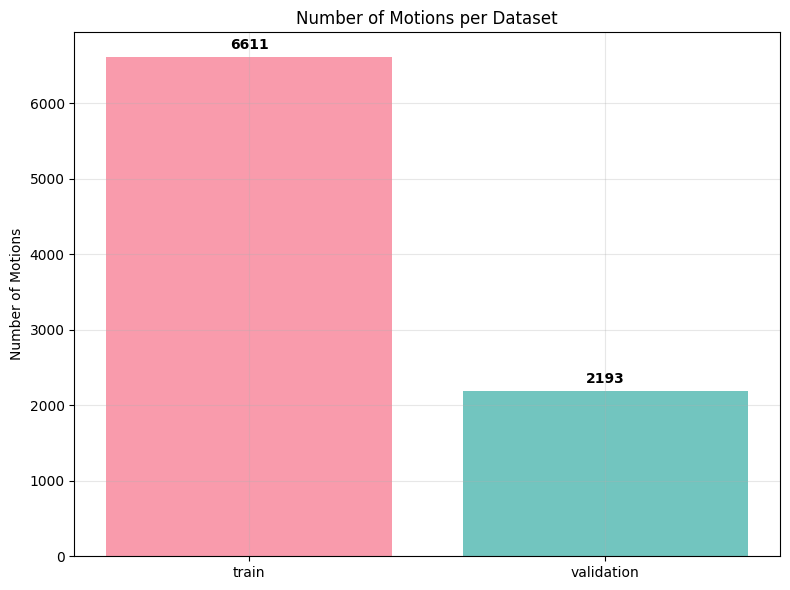

In [17]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6))

motion_counts = [len(analysis['motion_lengths_frames']) for analysis in analyses]
colors = sns.color_palette("husl", len(motion_counts))

bars = ax.bar(split_names, motion_counts, color=colors, alpha=0.7)
ax.set_title('Number of Motions per Dataset')
ax.set_ylabel('Number of Motions')
ax.grid(True, alpha=0.3)

for bar, count in zip(bars, motion_counts):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + max(motion_counts)*0.01, 
            str(count), ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

<div class="alert alert-info">

#### **Motion Length Distribution**

This shows the distribution of motion sequence lengths in both frames and seconds, with horizontal lines indicating minimum, maximum, and average values.

</div>

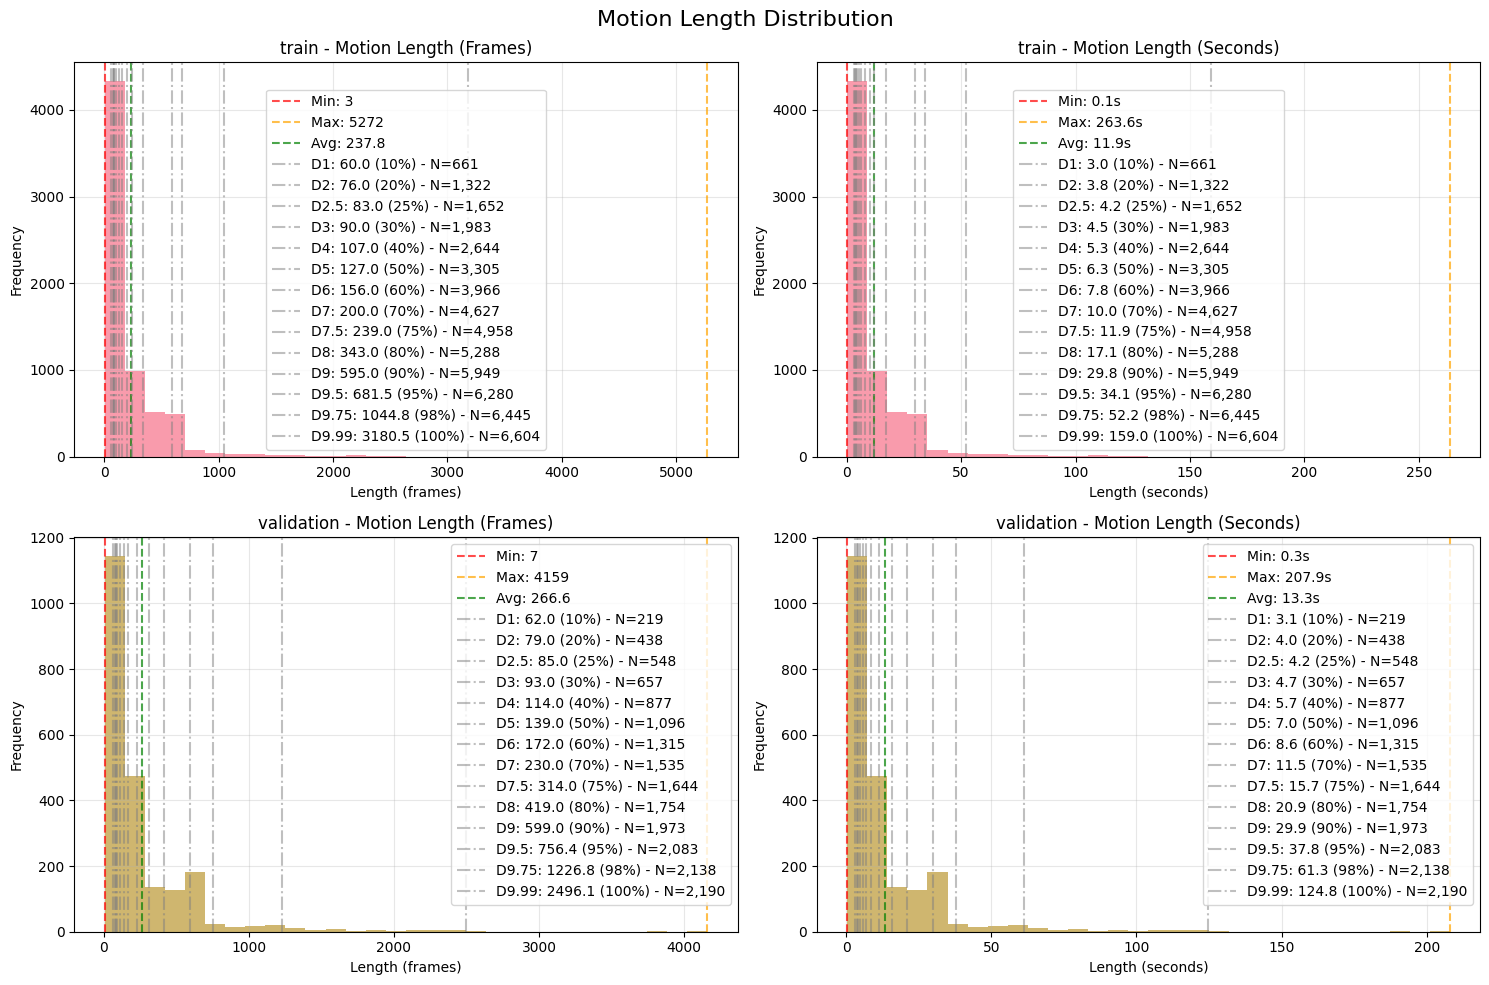

In [18]:
fig, axes = plt.subplots(len(analyses), 2, figsize=(15, 10))
fig.suptitle('Motion Length Distribution', fontsize=16)

for i, analysis in enumerate(analyses):
    name = analysis['split_name']
    lengths_frames = analysis['motion_lengths_frames']
    lengths_seconds = analysis['motion_lengths_seconds']
    
    if lengths_frames:
        # NOTE: frames distribution
        axes[i, 0].hist(lengths_frames, bins=30, alpha=0.7, color=f'C{i}')
        axes[i, 0].set_title(f'{name} - Motion Length (Frames)')
        axes[i, 0].set_xlabel('Length (frames)')
        axes[i, 0].set_ylabel('Frequency')
        axes[i, 0].grid(True, alpha=0.3)
        
        min_frames = np.min(lengths_frames)
        max_frames = np.max(lengths_frames)
        avg_frames = np.mean(lengths_frames)
        
        axes[i, 0].axvline(min_frames, color='red', linestyle='--', alpha=0.7, label=f'Min: {min_frames}')
        axes[i, 0].axvline(max_frames, color='orange', linestyle='--', alpha=0.7, label=f'Max: {max_frames}')
        axes[i, 0].axvline(avg_frames, color='green', linestyle='--', alpha=0.7, label=f'Avg: {avg_frames:.1f}')
        
        for d in DECILES:
            decile = np.percentile(lengths_frames, d*10)
            # axes[i, 0].axvline(decile, color='gray', linestyle='-.', alpha=0.5, label=f'D{d}: {decile:.1f}')
            axes[i, 0].axvline(
                decile,
                color='gray',
                linestyle='-.',
                alpha=0.5,
                label=f'D{d}: {decile:.1f} ({d*10:.0f}%) - N={int(len(lengths_frames)*d/10):,}'
            )
        axes[i, 0].legend()
        
        # NOTE: seconds distribution
        axes[i, 1].hist(lengths_seconds, bins=30, alpha=0.7, color=f'C{i}')
        axes[i, 1].set_title(f'{name} - Motion Length (Seconds)')
        axes[i, 1].set_xlabel('Length (seconds)')
        axes[i, 1].set_ylabel('Frequency')
        axes[i, 1].grid(True, alpha=0.3)
        
        min_seconds = np.min(lengths_seconds)
        max_seconds = np.max(lengths_seconds)
        avg_seconds = np.mean(lengths_seconds)
        
        axes[i, 1].axvline(min_seconds, color='red', linestyle='--', alpha=0.7, label=f'Min: {min_seconds:.1f}s')
        axes[i, 1].axvline(max_seconds, color='orange', linestyle='--', alpha=0.7, label=f'Max: {max_seconds:.1f}s')
        axes[i, 1].axvline(avg_seconds, color='green', linestyle='--', alpha=0.7, label=f'Avg: {avg_seconds:.1f}s')
        
        for d in DECILES:
            decile = np.percentile(lengths_seconds, d*10)
            # axes[i, 1].axvline(decile, color='gray', linestyle='-.', alpha=0.5, label=f'D{d}: {decile:.1f}s')
            axes[i, 1].axvline(
                decile,
                color='gray',
                linestyle='-.',
                alpha=0.5,
                label=f'D{d}: {decile:.1f} ({d*10:.0f}%) - N={int(len(lengths_seconds)*d/10):,}'
            )
        axes[i, 1].legend()

plt.tight_layout()
plt.show()

<div class="alert alert-info">

#### **Prompts per Motion Distribution**

This shows how many prompts are associated with each motion sequence, with horizontal lines indicating minimum, maximum, and average values.

</div>

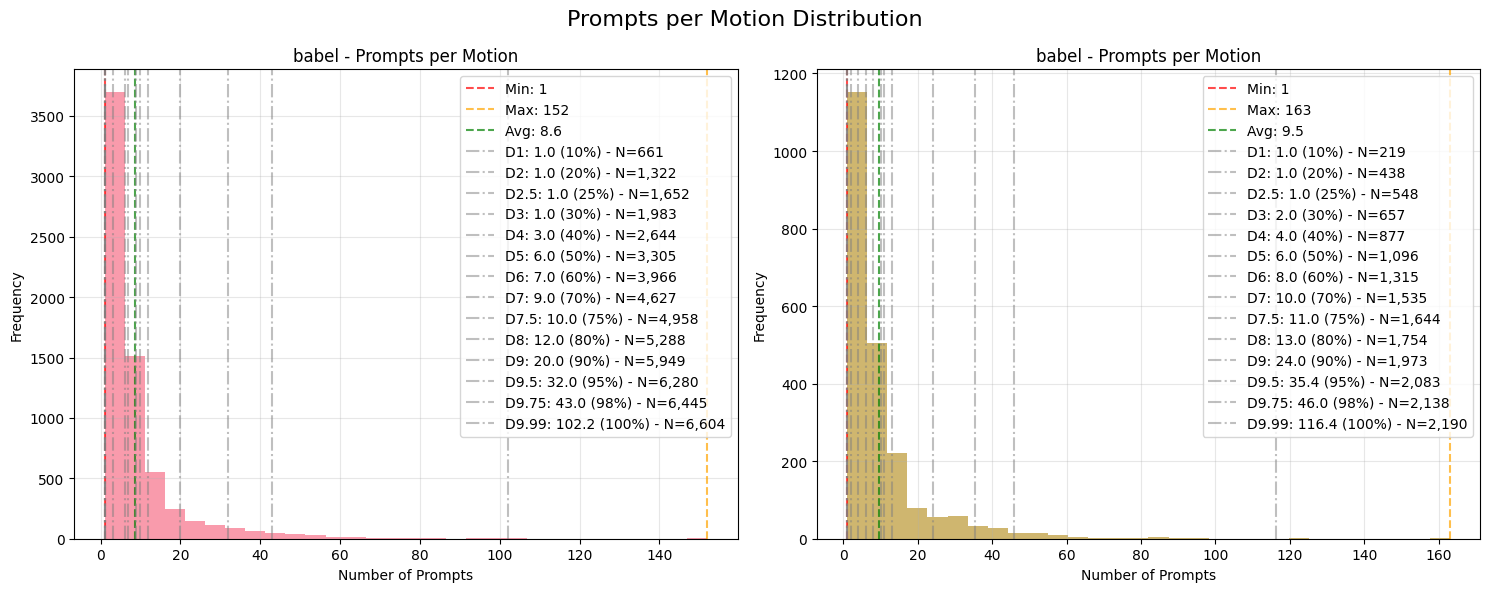

In [19]:
fig, axes = plt.subplots(1, len(analyses), figsize=(15, 6))
fig.suptitle('Prompts per Motion Distribution', fontsize=16)

for i, analysis in enumerate(analyses):
    name = analysis['dataset_name']
    prompts_per_motion = analysis['sample_prompt_counts']
    
    if prompts_per_motion:
        axes[i].hist(prompts_per_motion, bins=30, alpha=0.7, color=f'C{i}')
        axes[i].set_title(f'{name} - Prompts per Motion')
        axes[i].set_xlabel('Number of Prompts')
        axes[i].set_ylabel('Frequency')
        axes[i].grid(True, alpha=0.3)
        
        min_prompts = np.min(prompts_per_motion)
        max_prompts = np.max(prompts_per_motion)
        avg_prompts = np.mean(prompts_per_motion)
        
        axes[i].axvline(min_prompts, color='red', linestyle='--', alpha=0.7, label=f'Min: {min_prompts}')
        axes[i].axvline(max_prompts, color='orange', linestyle='--', alpha=0.7, label=f'Max: {max_prompts}')
        axes[i].axvline(avg_prompts, color='green', linestyle='--', alpha=0.7, label=f'Avg: {avg_prompts:.1f}')
        
        for d in DECILES:
            decile = np.percentile(prompts_per_motion, d*10)
            # axes[i].axvline(decile, color='gray', linestyle='-.', alpha=0.5, label=f'D{d}: {decile:.1f}')
            axes[i].axvline(
                decile,
                color='gray',
                linestyle='-.',
                alpha=0.5,
                label=f'D{d}: {decile:.1f} ({d*10:.0f}%) - N={int(len(prompts_per_motion)*d/10):,}'
            )
        axes[i].legend()

plt.tight_layout()
plt.show()

<div class="alert alert-info">

#### **Unique Prompts per Motion Distribution**

This shows the distribution of the number of unique prompts per motion sequence.

</div>

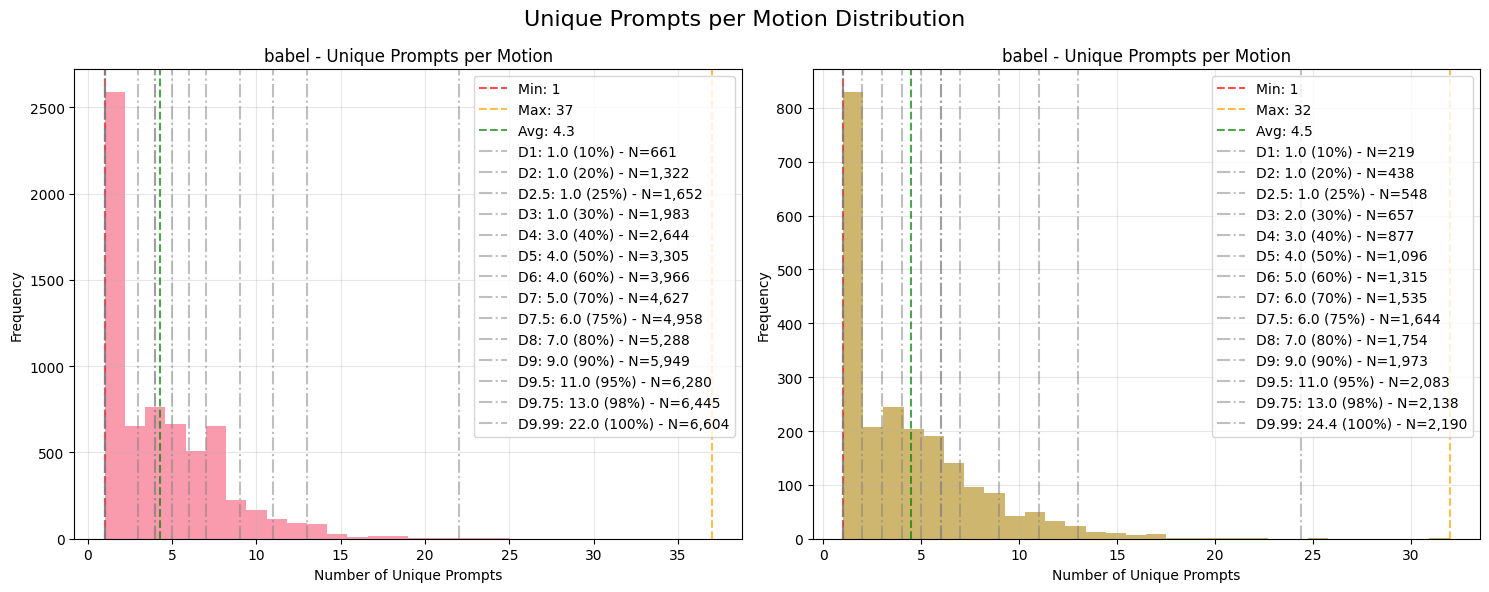

In [20]:
fig, axes = plt.subplots(1, len(analyses), figsize=(15, 6))
fig.suptitle('Unique Prompts per Motion Distribution', fontsize=16)

for i, analysis in enumerate(analyses):
    name = analysis['dataset_name']
    all_prompts = analysis['all_prompts']
    sample_prompt_counts = analysis['sample_prompt_counts']
    
    unique_counts = []
    idx = 0
    for count in sample_prompt_counts:
        prompts = all_prompts[idx:idx+count]
        unique_counts.append(len(set(prompts)))
        idx += count

    if unique_counts:
        axes[i].hist(unique_counts, bins=30, alpha=0.7, color=f'C{i}')
        axes[i].set_title(f'{name} - Unique Prompts per Motion')
        axes[i].set_xlabel('Number of Unique Prompts')
        axes[i].set_ylabel('Frequency')
        axes[i].grid(True, alpha=0.3)

        min_val = np.min(unique_counts)
        max_val = np.max(unique_counts)
        avg_val = np.mean(unique_counts)

        axes[i].axvline(min_val, color='red', linestyle='--', alpha=0.7, label=f'Min: {min_val}')
        axes[i].axvline(max_val, color='orange', linestyle='--', alpha=0.7, label=f'Max: {max_val}')
        axes[i].axvline(avg_val, color='green', linestyle='--', alpha=0.7, label=f'Avg: {avg_val:.1f}')
        
        for d in DECILES:
            decile = np.percentile(unique_counts, d*10)
            # axes[i].axvline(decile, color='gray', linestyle='-.', alpha=0.5, label=f'D{d}: {decile:.1f}')
            axes[i].axvline(
                decile,
                color='gray',
                linestyle='-.',
                alpha=0.5,
                label=f'D{d}: {decile:.1f} ({d*10:.0f}%) - N={int(len(unique_counts)*d/10):,}'
            )
            
        axes[i].legend()

plt.tight_layout()
plt.show()

<div class="alert alert-info">

#### **Spans per Motion Distribution**

This shows how many spans (temporal segments) are associated with each motion sequence, with horizontal lines indicating minimum, maximum, and average values.

</div>

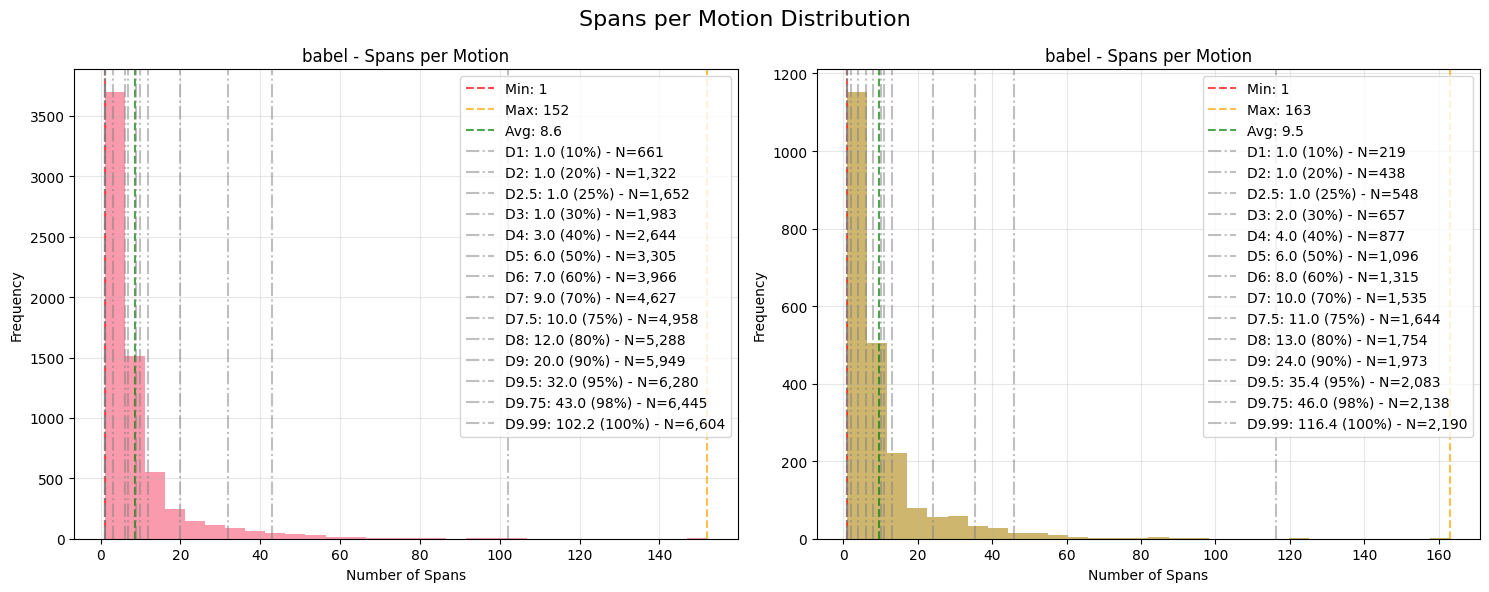

In [21]:
fig, axes = plt.subplots(1, len(analyses), figsize=(15, 6))
fig.suptitle('Spans per Motion Distribution', fontsize=16)

for i, analysis in enumerate(analyses):
    name = analysis['dataset_name']
    spans_per_motion = analysis['spans_per_motion']
    
    if spans_per_motion:
        axes[i].hist(spans_per_motion, bins=30, alpha=0.7, color=f'C{i}')
        axes[i].set_title(f'{name} - Spans per Motion')
        axes[i].set_xlabel('Number of Spans')
        axes[i].set_ylabel('Frequency')
        axes[i].grid(True, alpha=0.3)
        
        min_spans = np.min(spans_per_motion)
        max_spans = np.max(spans_per_motion)
        avg_spans = np.mean(spans_per_motion)
        
        axes[i].axvline(min_spans, color='red', linestyle='--', alpha=0.7, label=f'Min: {min_spans}')
        axes[i].axvline(max_spans, color='orange', linestyle='--', alpha=0.7, label=f'Max: {max_spans}')
        axes[i].axvline(avg_spans, color='green', linestyle='--', alpha=0.7, label=f'Avg: {avg_spans:.1f}')
        
        for d in DECILES:
            decile = np.percentile(spans_per_motion, d*10)
            # axes[i].axvline(decile, color='gray', linestyle='-.', alpha=0.5, label=f'D{d}: {decile:.1f}')
            axes[i].axvline(
                decile,
                color='gray',
                linestyle='-.',
                alpha=0.5,
                label=f'D{d}: {decile:.1f} ({d*10:.0f}%) - N={int(len(spans_per_motion)*d/10):,}'
            )
        axes[i].legend()

plt.tight_layout()
plt.show()

<div class="alert alert-info">

#### **Spans Duration Distribution**

This shows the distribution of individual span durations in frames, with horizontal lines indicating minimum, maximum, and average values.

</div>

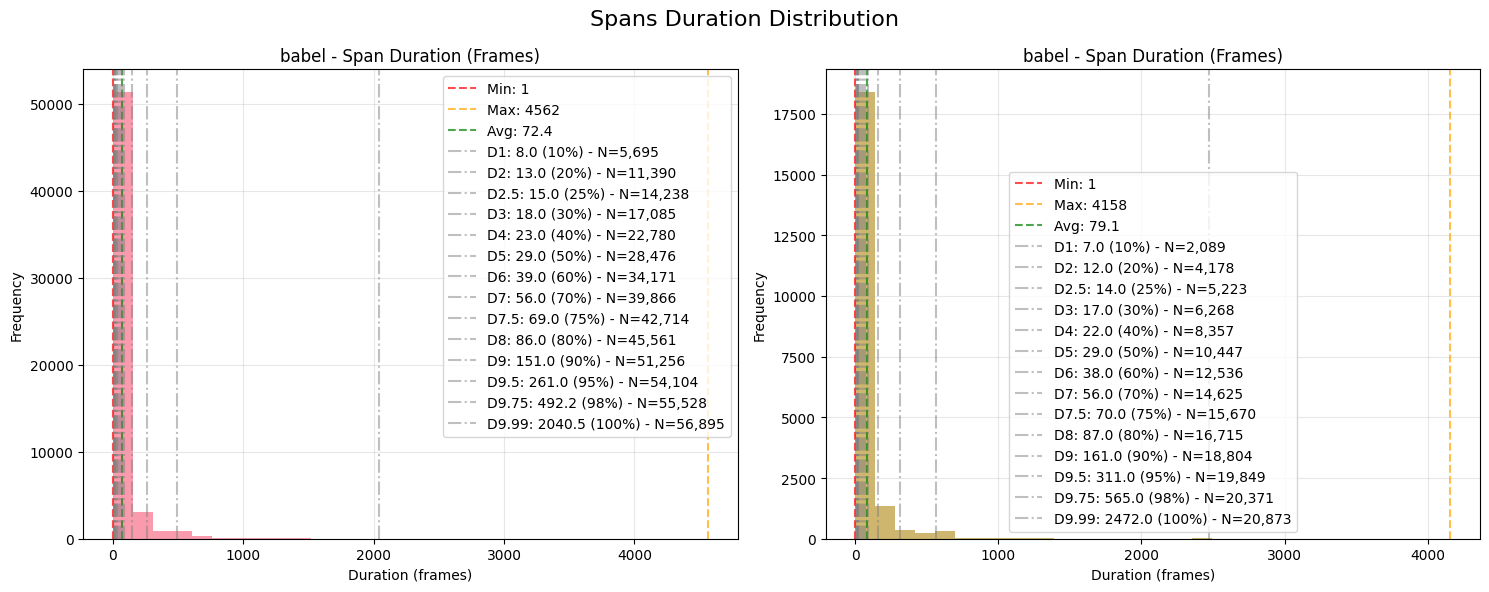

In [22]:
fig, axes = plt.subplots(1, len(analyses), figsize=(15, 6))
fig.suptitle('Spans Duration Distribution', fontsize=16)

for i, analysis in enumerate(analyses):
    name = analysis['dataset_name']
    span_durations = analysis['durations']
    
    if span_durations:
        axes[i].hist(span_durations, bins=30, alpha=0.7, color=f'C{i}')
        axes[i].set_title(f'{name} - Span Duration (Frames)')
        axes[i].set_xlabel('Duration (frames)')
        axes[i].set_ylabel('Frequency')
        axes[i].grid(True, alpha=0.3)
        
        min_duration = np.min(span_durations)
        max_duration = np.max(span_durations)
        avg_duration = np.mean(span_durations)
        
        axes[i].axvline(min_duration, color='red', linestyle='--', alpha=0.7, label=f'Min: {min_duration}')
        axes[i].axvline(max_duration, color='orange', linestyle='--', alpha=0.7, label=f'Max: {max_duration}')
        axes[i].axvline(avg_duration, color='green', linestyle='--', alpha=0.7, label=f'Avg: {avg_duration:.1f}')
        
        for d in DECILES:
            decile = np.percentile(span_durations, d*10)
            # axes[i].axvline(decile, color='gray', linestyle='-.', alpha=0.5, label=f'D{d}: {decile:.1f}')
            axes[i].axvline(
                decile,
                color='gray',
                linestyle='-.',
                alpha=0.5,
                label=f'D{d}: {decile:.1f} ({d*10:.0f}%) - N={int(len(span_durations)*d/10):,}'
            )
        axes[i].legend()

plt.tight_layout()
plt.show()

<div class="alert alert-info">

#### **Total Spans per Motion (Per Motion Analysis)**

This shows the total span duration per motion sequence, indicating how much of each motion is covered by annotated spans.

</div>

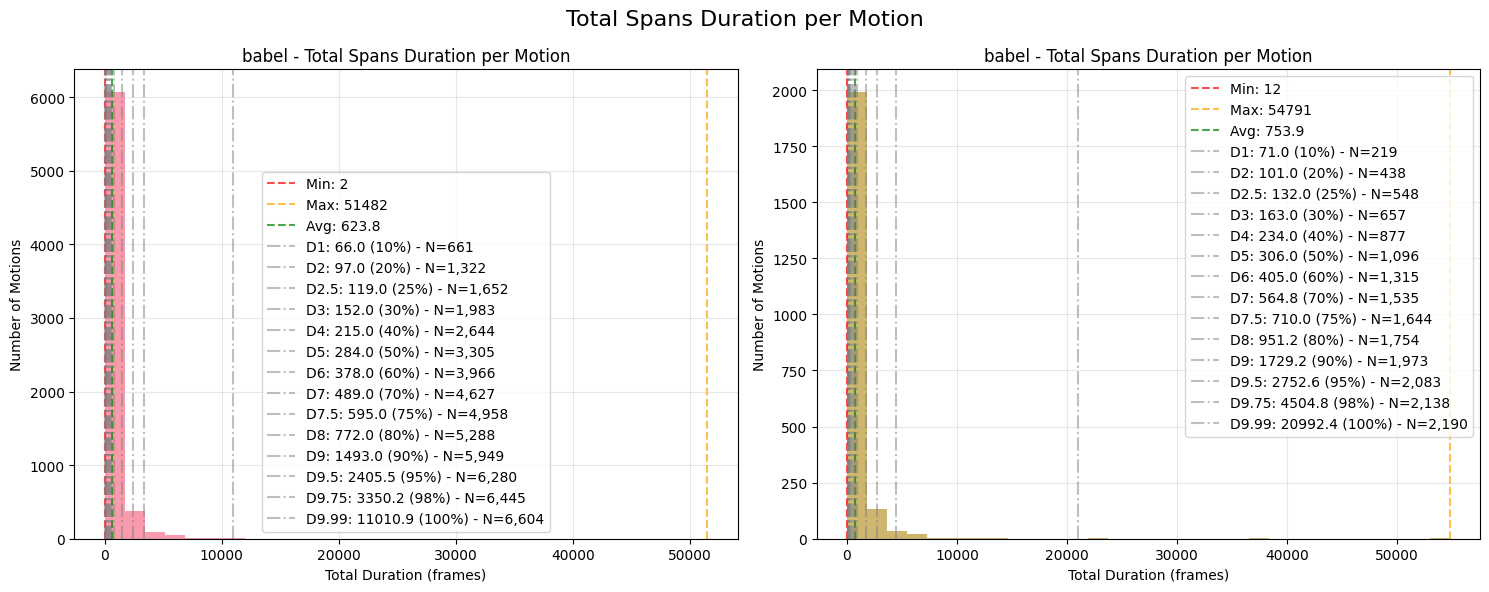

In [23]:
fig, axes = plt.subplots(1, len(analyses), figsize=(15, 6))
fig.suptitle('Total Spans Duration per Motion', fontsize=16)

for i, analysis in enumerate(analyses):
    name = analysis['dataset_name']
    spans_durations_per_motion = analysis['spans_durations_per_motion']
    
    if spans_durations_per_motion:
        axes[i].hist(spans_durations_per_motion, bins=30, alpha=0.7, color=f'C{i}')
        axes[i].set_title(f'{name} - Total Spans Duration per Motion')
        axes[i].set_xlabel('Total Duration (frames)')
        axes[i].set_ylabel('Number of Motions')
        axes[i].grid(True, alpha=0.3)
        
        min_duration = np.min(spans_durations_per_motion)
        max_duration = np.max(spans_durations_per_motion)
        avg_duration = np.mean(spans_durations_per_motion)
        
        axes[i].axvline(min_duration, color='red', linestyle='--', alpha=0.7, label=f'Min: {min_duration}')
        axes[i].axvline(max_duration, color='orange', linestyle='--', alpha=0.7, label=f'Max: {max_duration}')
        axes[i].axvline(avg_duration, color='green', linestyle='--', alpha=0.7, label=f'Avg: {avg_duration:.1f}')
        
        for d in DECILES:
            decile = np.percentile(spans_durations_per_motion, d*10)
            # axes[i].axvline(decile, color='gray', linestyle='-.', alpha=0.5, label=f'D{d}: {decile:.1f}')
            axes[i].axvline(
                decile,
                color='gray',
                linestyle='-.',
                alpha=0.5,
                label=f'D{d}: {decile:.1f} ({d*10:.0f}%) - N={int(len(spans_durations_per_motion)*d/10):,}'
            )
        axes[i].legend()

plt.tight_layout()
plt.show()

<div class="alert alert-info">

#### **Proportion Analysis**

This shows the distribution (number of samples) for the different span coverage values.

</div>

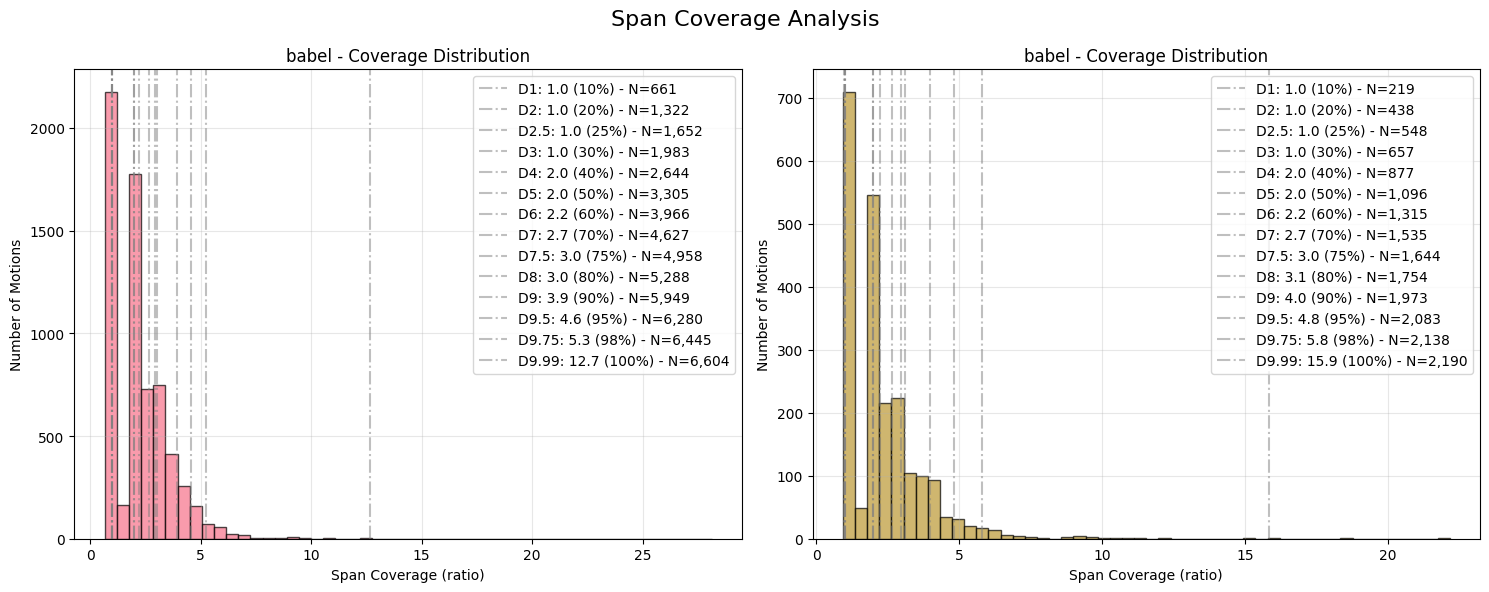

In [24]:
def calculate_span_coverage(analysis):
    """
    Calculate span coverage for each motion in the analysis.
    Coverage = total_spans_duration / motion_length
    """
    coverage_values = []
    
    motion_lengths = analysis['motion_lengths_frames']
    spans_durations = analysis['spans_durations_per_motion']
    
    for motion_length, total_span_duration in zip(motion_lengths, spans_durations):
        if motion_length > 0:
            coverage = total_span_duration / motion_length
            coverage_values.append(coverage)
            
    return coverage_values

fig, axes = plt.subplots(1, len(analyses), figsize=(15, 6))
if len(analyses) == 1:
    axes = axes.reshape(-1, 1)

fig.suptitle('Span Coverage Analysis', fontsize=16)

for i, analysis in enumerate(analyses):
    name = analysis['dataset_name']
    coverage_values = calculate_span_coverage(analysis)
    
    if not coverage_values:
        continue
        
    axes[i].hist(coverage_values, bins=50, alpha=0.7, color=f'C{i}', edgecolor='black')
    axes[i].set_title(f'{name} - Coverage Distribution')
    axes[i].set_xlabel('Span Coverage (ratio)')
    axes[i].set_ylabel('Number of Motions')
    axes[i].grid(True, alpha=0.3)
    
    for d in DECILES:
        decile = np.percentile(coverage_values, d*10)
        # axes[i].axvline(decile, color='gray', linestyle='-.', alpha=0.5, label=f'D{d}: {decile:.1f}')
        axes[i].axvline(
            decile,
            color='gray',
            linestyle='-.',
            alpha=0.5,
            label=f'D{d}: {decile:.1f} ({d*10:.0f}%) - N={int(len(coverage_values)*d/10):,}'
        )
    axes[i].legend()

plt.tight_layout()
plt.show()